In [2]:
from comet_ml import Experiment

api = 'HIZapbzNjFips0c32Co7gXkQZ'
experiment = Experiment(api_key=api, project_name="sirius-hw.1")


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.functional as F

import torchvision
from torchvision import transforms

COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/maximartemev/sirius-hw-1/466ecca8a86d473cbe95e15b7fc04bd6



В этой тетрадке вам предлагается обучить простую нейронную сверточную сеть на датасете CIFAR-100

In [3]:
# Заранее собранные датасеты

train_set = torchvision.datasets.CIFAR100(root='./cifar100-data',
                                          train=True,
                                          download=True,
                                          transform=transforms.ToTensor())
test_set = torchvision.datasets.CIFAR100(root='./cifar100-data',
                                         train=False,
                                         download=True, 
                                         transform=transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


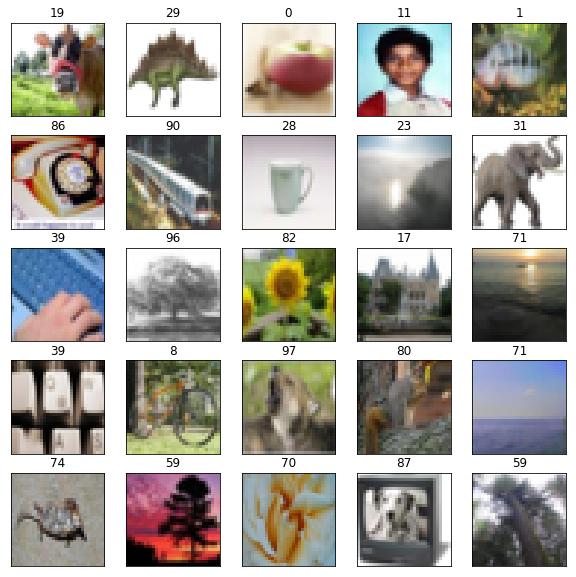

In [4]:
# CIFAR 100, 32x32 картинки

plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_set):
    if index >= 25:
        break
    plt.subplot(5, 5, index + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.yticks([])
    plt.xticks([])
    plt.title(str(label))
plt.show()

In [5]:
# Соберем все датасеты в даталоадере, соберем батчи 

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [6]:
batch = next(iter(train_loader))
# Первый элемент батча - тензор с картинками
print(batch[0].shape)
# Второй - тензор с правильными лейблами
print(batch[1].shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [7]:
class CifarModel(nn.Module):
    def __init__(self, ):
        super(CifarModel, self).__init__()
        # YOUR CODE
        
        self.preemb = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(3, 32, i, padding=i//2),
                nn.BatchNorm2d(32),
                nn.ReLU()
            )
        for i in [3, 5, 7, 9]])
        
        self.emb = nn.Sequential(
            nn.Conv2d(32*4, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.02),
            nn.Conv2d(128, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.02),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.02),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(16),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(8*8*16, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(512, 100),
        )
        
    def forward(self, x):
        # YOUR CODE
        x = torch.cat([module(x) for module in self.preemb], dim=1)
        return self.fc(self.emb(x).view(x.shape[0], -1))
        

In [8]:
model = CifarModel().cuda()

Теперь здесь определите какой лосс, какую метрику качества и какой оптимизатор вы будете использовать

In [9]:
# criterion = # YOUR CODE
# metric = # YOUR CODE
# optimizator = # YOUR CODE

In [10]:
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()
metric = accuracy_score
optimizator = torch.optim.Adam(model.parameters())

Здесь напишите свой цикл обучения, обучайте модель как минимум 10 эпох, логируйте качество модели на трейне и на тесте.

Подумайте про то, чтобы перестать использовать обычные питоновские графики для логирования.

Один из хороших вариантов - comet.ml, штука позволяет сохранять все метрики/лоссы и отрисовывать их в веб-тулзе

![image](https://embedwistia-a.akamaihd.net/deliveries/a8e5eadf35dada5083651913fd9258b6.webp?image_crop_resized=1022x838)

Постарайтесь получить accuracy больше чем 0.45

In [12]:
from tqdm import tqdm_notebook

for epoch in tqdm_notebook(range(100)):
    model.train()
    for ind, (image, label) in enumerate(train_loader):
        image = image.cuda()
        label = label.cuda()
        pred = model(image)
        loss = criterion(pred, label)
        loss.backward()
        optimizator.step()
        optimizator.zero_grad()
        experiment.log_metric("train/loss", loss.item())
        experiment.log_metric("train/accuracy", metric(label.cpu().data.numpy(),
                                                 torch.argmax(pred.cpu(), dim=1).data.numpy())
                             )
    model.eval()
    for ind, (image, label) in enumerate(test_loader):
        image = image.cuda()
        label = label.cuda()
        pred = model(image)
        loss = criterion(pred, label)
        experiment.log_metric("test/loss", loss.item())
        experiment.log_metric("test/accuracy", metric(label.cpu().data.numpy(),
                           torch.argmax(pred.cpu(), dim=1).data.numpy())
                             )


In [14]:
accs = []

for ind, (image, label) in enumerate(test_loader):
    image = image.cuda()
    label = label.cuda()
    pred = model(image)
    accs.append(metric(label.cpu().data.numpy(),
                torch.argmax(pred.cpu(), dim=1).data.numpy())
                )
print(np.mean(accs))

0.48652156549520764


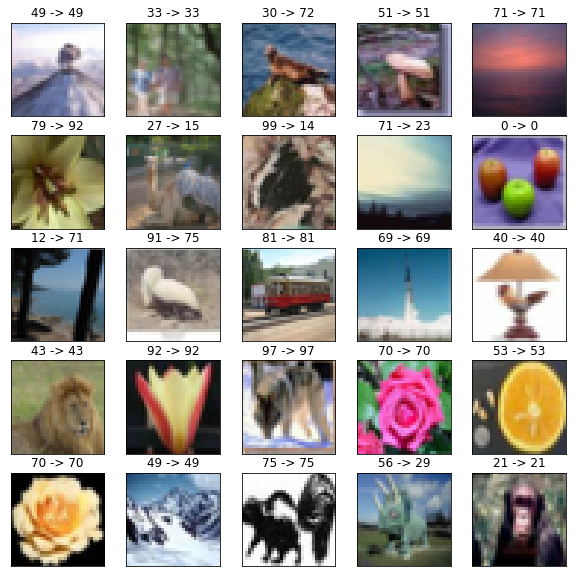

In [13]:
# CIFAR 100, 32x32 картинки
model.eval()

plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(test_set):
    if index >= 25:
        break
    plt.subplot(5, 5, index + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.yticks([])
    plt.xticks([])
    pred = torch.argmax(model(image.unsqueeze(0).cuda()), dim=1)
    plt.title("{} -> {}".format(pred.item(), label))
plt.show()

In [26]:
# YOUR CODE